## pset 05: the adventure of the telltale composition -10/16/24
---


In [4]:
import numpy as np
import matplotlib.pyplot as plt     
import pandas as pd                 # optional
import seaborn as sns               # optional

%matplotlib inline

## 1. testing Moriarty's method

### 1.1 load the data

In [5]:
# define function to handle multiple sequences in a file and returns a list of sequences
def load_fasta(filename):
    sequences= []
    with open(filename, 'r') as file:
        current_seq= ''
        for line in file:
            # check if the line starts with '>', indicating a new sequence header
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq= ''  # reset current_seq for the next sequence
            else:
                # if it's not a header, it's part of the sequence
                # strip whitespace and add to current_seq
                current_seq+= line.strip()
        # after the loop, add the last sequence if there is one
        if current_seq:
            sequences.append(current_seq)

    # return the list of all sequences found in the file
    return sequences
    
strep= load_fasta('strep-test.fa')
micro= load_fasta('micro-test.fa')
moriarty_neg= load_fasta('moriarty-neg.fa')

### 1.2 implement Moriarty's secret scoring method

In [6]:
def score_seq(sequence):
    # score +1 for each C or G, and -1 for each A or T
    return sum(1 if base in 'CG' else -1 for base in sequence.upper())

# calculate scores for both datasets
strep_scores= np.array([score_seq(seq) for seq in strep])
micro_scores= np.array([score_seq(seq) for seq in micro])


### 1.3 plot histogram and ROC curve 

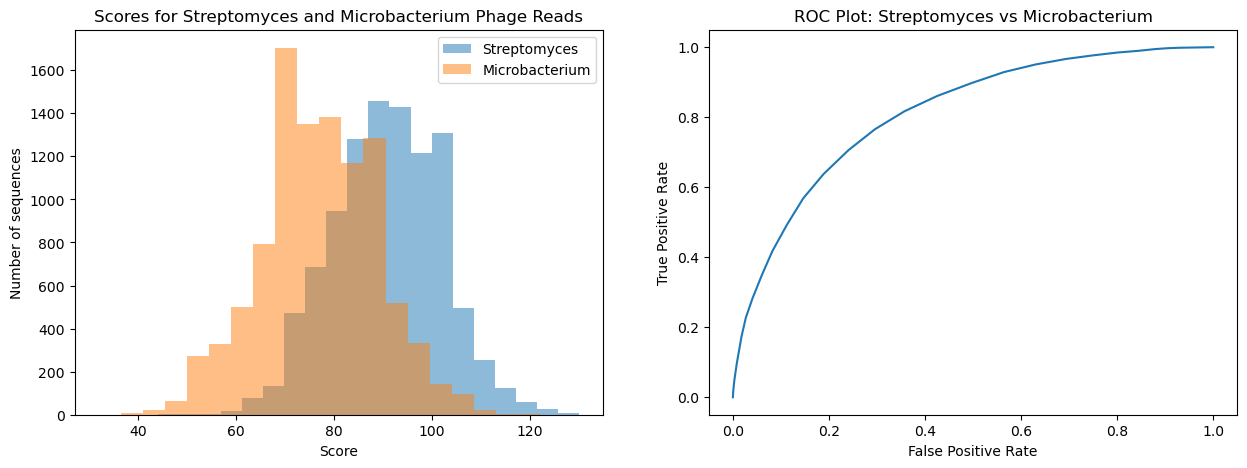

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # plot them side by side

# plot histogram
ax1.hist(strep_scores, bins=20, alpha=0.5, label='Streptomyces')
ax1.hist(micro_scores, bins=20, alpha=0.5, label='Microbacterium')
ax1.set_xlabel('Score')
ax1.set_ylabel('Number of sequences')
ax1.legend()
ax1.set_title("Scores for Streptomyces and Microbacterium Phage Reads")

# referenced section notes for the following 
# find minimum and maximum scores across both datasets
min_score= min(np.min(strep_scores), np.min(micro_scores))
max_score= max(np.max(strep_scores), np.max(micro_scores))

num_thresh= 1000
threshold_scores= np.linspace(min_score, max_score, num_thresh)

# set up arrays for true positives, false positives, etc
TP= np.zeros(num_thresh)
FP= np.zeros(num_thresh)
TN= np.zeros(num_thresh)
FN= np.zeros(num_thresh)

# calculate TP, FP, TN, FN for each threshold
for i, score in enumerate(threshold_scores):
    TP[i]= np.sum(strep_scores >= score)
    FP[i]= np.sum(micro_scores >= score)
    TN[i]= np.sum(micro_scores < score)
    FN[i]= np.sum(strep_scores < score)

# calculate true positive rate and false positive rate
TPR= TP/(TP+ FN)
FPR= FP/(FP+ TN)

# plot ROC 
ax2.plot(FPR, TPR)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Plot: Streptomyces vs Microbacterium')
plt.show()

# look at the frequency of GC for the datasets 
# What happens if the genomes are similar in GC content? doesn't discriminate... 

The histogram shows overlapping distributions for Streptomyces and Microbacterium phage reads, unlike the clear separation Moriarty showed against random sequences.

The ROC curve shows that Moriarty's method does not perfectly discriminate between Streptomyces and Microbacterium phage reads. There's a trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity). 

Moriarty compared Streptomyces phage reads to random sequences with uniform base composition whereas we compared Streptomyces phage reads to Microbacterium phage reads. Moriarty's simple scoring method (+1 for G/C, -1 for A/T) is essentially just measuring GC content. Let's take a look at the average GC content for the genomes we're working with:

In [12]:
# calculate GC content for each sequence in both datasets
def gc_content(sequence):
    gc_count= sequence.count('G')+ sequence.count('C')
    return gc_count/len(sequence)* 100 # convert to percentage

strep_gc= [gc_content(seq) for seq in strep]
micro_gc= [gc_content(seq) for seq in micro]
neg_gc= [gc_content(seq) for seq in moriarty_neg]

print(f"GC frequency for Streptomyces: {np.mean(strep_gc):.1f}%")
print(f"GC frequency for Microbacterium: {np.mean(micro_gc):.1f}%")
print(f"GC frequency for Moriarty's random sequence: {np.mean(neg_gc):.1f}%")


GC frequency for Streptomyces: 72.7%
GC frequency for Microbacterium: 69.2%
GC frequency for Moriarty's random sequence: 50.0%


This explains why Moriarty's method appears to work perfectly: a 22.7% point difference in GC content between Streptomyces (72.7% GC) and a randomly uniform sequence (50% GC)is more easy to detect with a basic counting method.

However, when we are working with real sequences, the much smaller difference in GC content between Streptomyces (72.7%) and Microbacterium (69.2%) -- only 3.5 percentage points-- explains why our method struggles in actual application.
This small difference is not easily distinguished by Moriarty's +1/-1 counting method. 

While GC content can sometimes be informative, this case shows it's not sufficient for distinguishing closely related or similar organisms. Since both phage types have high GC content, this similarity makes discrimination much more challenging. To improve upon Moriarty's method, we can use higher-order Markov models to capture more complex patterns in the sequences. 

## 2. making our own method

### 2.1 implement a second-order Markov model

In [15]:
def markov_model(sequence):
    triplet_counts = {}  # dictionary to store counts 
    pair_counts = {}
    
    # count occurrences of triplets and pairs for given sequence 
    for i in range(len(sequence) - 2):
        # subtract 2 from the length because we're looking at triplets, so we stop 2 characters before the end

        # extract triplets and pairs
        # triplet = x_i_minus_2, x_i_minus_1, x_i
        triplet = sequence[i:i+3]
        # pair = x_i_minus_2, x_i_minus_1
        pair = sequence[i:i+2]

        # if we've seen the triplet before, increase its count
        # if we haven't seen the triplet before, start counting it with a count of 1
        # do the same with pairs 
        if triplet in triplet_counts:
            triplet_counts[triplet] += 1
        else:
            triplet_counts[triplet] = 1
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1
    
    # calculate conditional probabilities
    model = {}

    # iterate through all observed triplets and their counts
    for triplet, count in triplet_counts.items():

        # extract the pair (x_i-2, x_i-1) from the triplet
        pair = triplet[:2]

        # compute P(x_i| x_i-2, x_i-1) = count(x_i-2, x_i-1, x_i) / count(x_i-2, x_i-1)
        # this is the probability of seeing x_i, given that we just saw x_i-2 and x_i-1
        model[triplet] = count/ pair_counts[pair]
    
    return model
    

### 2.2 train models on PapayaSalad and OscarSo genomes

In [17]:
def parse_fasta(file):
    with open(file, 'r') as f:
        header = f.readline().strip()
        seq = ''.join(line.strip() for line in f)
    return seq

papaya_salad = parse_fasta('PapayaSalad.fa')
oscar_so = parse_fasta('OscarSo.fa')

strep_model = markov_model(papaya_salad)
micro_model = markov_model(oscar_so)


### 2.3 implement log likelihood ratio scoring 

In [19]:
def log_score(sequence, model1, model2):
    score = 0

    # iterate through sequence, looking at each triplet 
    for i in range(len(sequence) - 2):
        triplet = sequence[i:i+3]
        p1 = model1.get(triplet) 
        p2 = model2.get(triplet)
        # compute difference between logs and add it to the score 
        score += np.log(p1) - np.log(p2)
        
    # compute log likelihood ratio score for a sequence read
    return score
    
strep_logscores = np.array([log_score(seq, strep_model, micro_model) for seq in strep])
micro_logscores = np.array([log_score(seq, strep_model, micro_model) for seq in micro])

# log score is useful (can just subtract)

### 2.4 plot histogram and ROC curve 

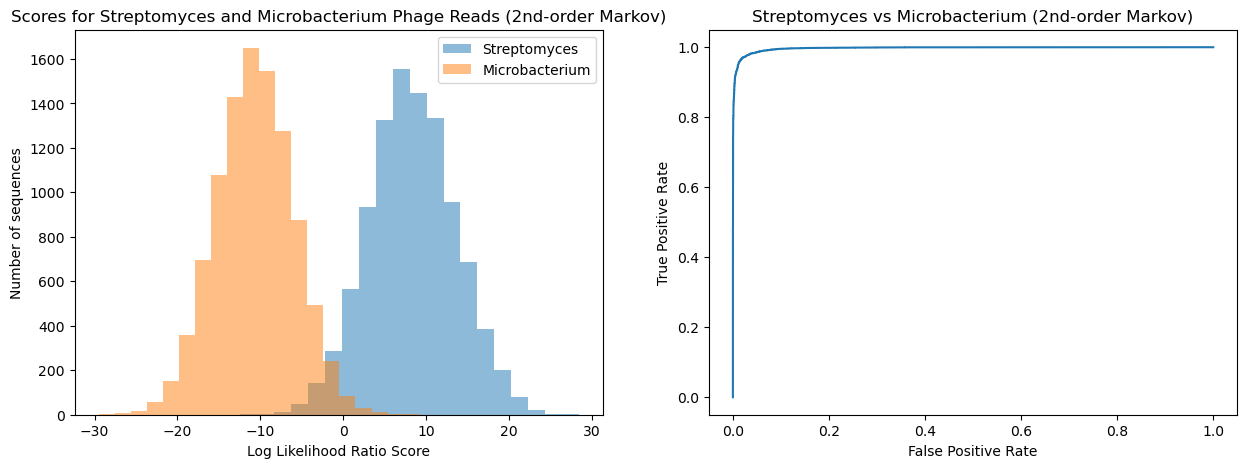

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(strep_logscores, bins= 20, alpha= 0.5, label= 'Streptomyces')
ax1.hist(micro_logscores, bins= 20, alpha= 0.5, label= 'Microbacterium')
ax1.set_xlabel('Log Likelihood Ratio Score')
ax1.set_ylabel('Number of sequences')
ax1.legend()
ax1.set_title("Scores for Streptomyces and Microbacterium Phage Reads (2nd-order Markov)")

def calculate_roc(pos_scores, neg_scores):
    thresholds = np.sort(np.concatenate([pos_scores, neg_scores]))
    tpr = np.zeros(len(thresholds))
    fpr = np.zeros(len(thresholds))
    for i, threshold in enumerate(thresholds):
        tp = np.sum(pos_scores >= threshold)
        fp = np.sum(neg_scores >= threshold)
        tn = np.sum(neg_scores < threshold)
        fn = np.sum(pos_scores < threshold)
        tpr[i] = tp/ (tp + fn)
        fpr[i] = fp/ (fp + tn)
    return fpr, tpr

fpr, tpr = calculate_roc(strep_logscores, micro_logscores)

ax2.plot(fpr, tpr)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate') # sensitivity 
ax2.set_title('Streptomyces vs Microbacterium (2nd-order Markov)')
plt.show()

# roc curve closer to the left corner, the better discrimination


This 2nd-order Markov model is better than Moriarty's model as shown by the fewer score overlap and the high sensitivity at 0% FPR because it captures more complex and specific patterns that differentiate between the two phage types. By considering the context of each base (the two preceding bases), it can learn and use species-specific sequence preferences that go beyond a Moriarity's method of considering only the overall GC content and ignoring the order of bases. 

For example, if a certain triplet "ACG" is common in Streptomyces but rare in Microbacterium, the Markov model would assign a high probability to this triplet for Streptomyces and a lower probability for Microbacterium. Moriarty's method would treat this triplet the same as any other triplet with one G/C, missing this distinguishing pattern. The usage of log-likelihood ratios also provides a more statistically grounded way of comparing sequences. Instead of a simple +1 or -1 for each base, it considers how much more or less likely each triplet is in one species compared to the other, sharpening our degree of discrimination between the two phages.


### 3. how good is our method?

### 3.1 find the threshold for 90% sensitivity

In [24]:
# lab wants to achieve 90% sensitivity for detecting Streptomyces phage reads...
sorted_strep = np.sort(strep_logscores)
thres_index = int(len(strep_logscores)* 0.1)  # 10% from the bottom for 90% sensitivity
threshold = sorted_strep[thres_index]

print(f"Score threshold for 90% sensitivity: {threshold: .4f}")

# when we set our classification threshold to 1.7155, 
# we correctly identify 90% of the Streptomyces phage reads

Score threshold for 90% sensitivity:  1.7155


### 3.2 estimate for the false positive rate at that threshold

In [26]:
false_pos = np.sum(micro_logscores >= threshold)
true_neg = np.sum(micro_logscores < threshold)
false_pos_rate = false_pos/ (false_pos+ true_neg)

print(f"False positive rate at this threshold: {false_pos_rate}")

# this counts how many Microbacterium scores are above the threshold (false positives)

False positive rate at this threshold: 0.0038


This FPR tells us that only 0.38% of Microbacterium phage reads are incorrectly classified as Streptomyces at this threshold, which is seems good! At first glance...

### 3.3 calculate false discovery rate (FDR)

In [28]:
reads = 1000000  # assume we have 1 million reads total
strep_reads = reads* 0.001  # 0.1% are Streptomyces (true fraction) 
micro_reads = reads* 0.999  # 99.9% are Microbacterium

true_positives = 0.9* strep_reads  # 90% of Streptomyces reads (sensitivity)
false_positives = false_pos_rate* micro_reads

# fdr = portion that are false positives 
fdr = false_positives /(false_positives+ true_positives)

print(f"False discovery rate: {fdr: .4f}")

# many papers would show this low false positive rates at this threshold 
# but if you check the FDR, for the population split, there is roughly 80% of the data being misclassified 
# population is extremely biased 
# our model is actually not that great :( 


False discovery rate:  0.8084


FDR tells us what fraction of our Streptomyces classifications are actually false positives. A high FDR would mean that many of our supposed Streptomyces reads are actually from Microbacterium, which is what our code is telling us and this is bad!

This is an example of the "needle in the haystack problem" mentioned in lecture. This high FDR means that about 80.84% of the reads we classify as Streptomyces are actually false positives from Microbacterium (falsing classifying at a high rate). This occurs despite 90% sensitivity and 0.38% false positive rate because of the extreme imbalance in the dataset (highly skewed sample composition-- 99.9% Microbacterium phage and only 0.1% Streptomyces phage). This misleading sense of the accuracy in this classification process suggests that our model is better than Moriarty's but not that great, at the theshold we've chosen in a biased population. 


In [30]:
# let's test out a population split- what if it's 50/50...

# assuming we keep the same sensitivity (90%) and false positive rate (0.38%)
total_reads = 1000000  # Total reads
strepto_reads = total_reads * 0.5  # 50% are Streptomyces
microb_reads = total_reads * 0.5  # 50% are Microbacterium

test_true_pos = 0.9 * strepto_reads  # 90% sensitivity
test_false_pos = 0.0038 * microb_reads  # 0.38% false positive rate

fdr_50_50 = test_false_pos / (test_false_pos + test_true_pos)

print(f"False discovery rate (50/50 split): {fdr_50_50:.4f}")

False discovery rate (50/50 split): 0.0042


Here, when the population is 50/50 split, the FDR has dropped from about 80.84% to just 0.42%. This is a massive improvement in classification reliability, showing how strongly the dataset balance affects the performance of the model, even when sensitivity and specificity remain the same.

In this case, while our method is good at distinguishing between the two types of phage in a balanced test set, it struggles to provide reliable classifications in the actual sample where Streptomyces phage is very rare. This illustrates why it's important to consider the context and composition of our data, especially in genomics and other fields when you're looking for rare events. 

In [32]:
# watermark 
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.25.0

numpy     : 1.26.4
matplotlib: 3.8.4
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.0.11

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

